In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.python.data import Dataset

In [25]:
# 1. Wczytanie datasetu
full_df = pd.read_csv('../dataset/larger_full_datasets.csv')
full_df.head()



,sample_id,frame,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,landmark_21_x,landmark_21_y,landmark_21_z
0,1,0,A,0.345417,0.648431,-1.125724e-07,0.363545,0.620765,-0.010274,0.367171,...,-0.003865,0.321722,0.551512,-0.008457,0.326903,0.565844,-0.005724,0.329682,0.577548,-0.001789
1,1,1,A,0.366266,0.597102,-9.622672e-08,0.391580,0.578109,-0.012907,0.406190,...,0.000685,0.356418,0.497935,-0.004451,0.361665,0.515749,-0.001988,0.363353,0.523833,0.002337
2,1,2,A,0.400966,0.572690,-1.089629e-07,0.424555,0.552354,-0.004017,0.439723,...,-0.004296,0.383425,0.481909,-0.009304,0.389207,0.502081,-0.005430,0.391897,0.513775,-0.000924
3,1,3,A,0.418257,0.573744,-1.190043e-07,0.441344,0.563031,-0.007786,0.460869,...,-0.002903,0.402536,0.489501,-0.009669,0.406139,0.510639,-0.006567,0.409394,0.523706,-0.001918
4,1,4,A,0.431913,0.582072,-1.241054e-07,0.453692,0.577044,-0.009167,0.474907,...,-0.004793,0.417201,0.501486,-0.012369,0.419653,0.524298,-0.008715,0.422120,0.535854,-0.003439


In [26]:
# 2. Wstępne przetwarzanie
df = full_df.drop(columns=['user_id'], errors='ignore')
df['label'] = df['label'].astype('category')

In [29]:
from utils.dataset_tools import DatasetTools

# 3. Podział na sekwencje (X, y)
SEQUENCE_LENGTH = 30
FEATURE_DIM = 63  # 21 punktów * 3 współrzędne

def divide_into_sequences(df):
    sequences, labels = [], []
    for sample_id, group in df.groupby('sample_id'):
        group = group.sort_values('frame').reset_index(drop=True)
        label = group.loc[0, 'label']

        data = group.drop(columns=['sample_id', 'frame', 'label'], errors='ignore').values

        sequences.append(data[:30])
        labels.append(label)

    return np.array(sequences), np.array(labels)

X_all, y_all = divide_into_sequences(df)

print("Typ X_all:", type(X_all), " | shape:", getattr(X_all, "shape", None))
print("Typ y_all:", type(y_all), " | shape:", getattr(y_all, "shape", None))

Typ X_all: <class 'numpy.ndarray'>  | shape: (2946, 30, 63)
Typ y_all: <class 'numpy.ndarray'>  | shape: (2946,)


In [33]:
# Tworzymy mapę sample_id -> label
label_map = full_df.groupby('sample_id')['label'].first().to_dict()

# Pobieramy wszystkie unikalne sample_id w kolejności, w jakiej zostały podzielone na sekwencje
sample_ids = full_df['sample_id'].unique()

for idx, sample_id in enumerate(sample_ids):
    y_label = y_all[idx]             # label z sekwencji
    true_label = label_map[sample_id]  # prawdziwy label z df
    if y_label != true_label:
        print(f"Niezgodny label w sample_id {sample_id}: sekwencja={y_label}, df={true_label}")


In [ ]:
del df, full_df

In [34]:
# 4. Normalizacja względem nadgarstka pierwszej klatki

X_all = np.array([DatasetTools.normalize_wrist(seq) for seq in X_all])


In [35]:
# 5. Kodowanie etykiet
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)
y_all_cat = to_categorical(y_all_enc)
num_classes = y_all_cat.shape[1]

In [38]:
# 6. Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_cat, test_size=0.15, stratify=y_all_enc,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=np.argmax(y_train, axis=1),
                                                  random_state=42)

In [39]:
def augment(sequence, augment_config):
    seq = tf.identity(sequence)

    # Flip co trzeciego kanału (np. X w XYZ), zakładając że FEATURE_DIM = 3n
    if augment_config.get('flip', False):
        # Maska dla osi X (co trzecia cecha, zaczynając od 0)
        x_indices = tf.range(tf.shape(seq)[-1]) % 3 == 0
        flip_mask = tf.cast(x_indices, seq.dtype)
        seq = seq * (1 - 2 * flip_mask)  # mnożenie przez -1 dla osi X

    # Szum Gaussowski
    if augment_config.get('gaussian_noise', False):
        noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev=0.01, dtype=tf.float64)
        seq += noise

    # Szum speckle (proporcjonalny do wartości oryginalnych)
    if augment_config.get('speckle_noise', False):
        noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev=0.01, dtype=tf.float64)
        noise = tf.sqrt(tf.abs(seq)) * noise
        noise = tf.where(
            noise < 0.01,
            tf.zeros_like(noise),
            noise
        )
        seq += seq * noise

    # Szum typu salt & pepper
    if augment_config.get('salt_pepper', False):
        prob = 0.01
        rnd = tf.random.uniform(tf.shape(seq))
        seq = tf.where(rnd < prob / 2, tf.zeros_like(seq), seq)
        seq = tf.where(rnd > 1 - prob / 2, tf.ones_like(seq), seq)

    return seq


In [40]:
# 8. Generator danych z augmentacją
def create_tf_dataset(X, y, batch_size=64, shuffle=True, augment_enabled=False, augment_config=None):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    def preprocess(x, y):
        if augment_enabled:
            x = augment(x, augment_config)
        return x, y

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [41]:
# 9. Przygotowanie zbiorów
train_ds = create_tf_dataset(X_train, y_train, augment_enabled=True, augment_config={
    'flip': True,
    'gaussian_noise': True,
    'speckle_noise': False,
    'salt_pepper': True
})
val_ds = create_tf_dataset(X_val, y_val, shuffle=False)
test_ds = create_tf_dataset(X_test, y_test, shuffle=False)

I0000 00:00:1760288067.533223   16865 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1731 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


In [19]:
# 10. Definicja modelu BiLSTM
from tensorflow.keras.layers import Layer, Input, LSTM, Bidirectional, Dense, Dropout, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def create_bilstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Jedna warstwa BiLSTM z 16 jednostkami
    x = Bidirectional(LSTM(16, return_sequences=True))(inputs)

    # Mechanizm Attention
    attention_weights = Dense(1, activation='tanh')(x)
    attention_weights = Lambda(lambda z: K.softmax(z, axis=1),
                               output_shape=lambda s: s)(attention_weights)

    context_vector = Multiply()([x, attention_weights])
    context_vector = Lambda(lambda z: K.sum(z, axis=1),
                            output_shape=lambda s: (s[0], s[2]))(context_vector)

    # Mniejsza warstwa gęsta
    x = Dense(32, activation='relu')(context_vector)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
# 11. Definicja modelu 1DCNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_1dcnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [23]:
from keras.src.callbacks import EarlyStopping
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

# 12. Trenowanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# BiLSTM z Attention
bilstm_model = create_bilstm_attention_model((30, 63), num_classes)
bilstm_model.summary()

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 30, 63)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 32)    │     10,240 │ input_layer_7[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 1)     │         33 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 30, 1)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 30, 32)    │          0 │ bidirectional_1[… │
│ (Multiply)          │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 32)        │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 36)        │      1,188 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,517 (48.89 KB)

 Trainable params: 12,517 (48.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1562 - loss: 3.0007 - val_accuracy: 0.6128 - val_loss: 1.1557
Epoch 2/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5081 - loss: 1.2997 - val_accuracy: 0.6813 - val_loss: 0.8204
Epoch 3/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6188 - loss: 0.9360 - val_accuracy: 0.7314 - val_loss: 0.6842
Epoch 4/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6935 - loss: 0.7637 - val_accuracy: 0.7620 - val_loss: 0.5880
Epoch 5/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7194 - loss: 0.7048 - val_accuracy: 0.8011 - val_loss: 0.5032
Epoch 6/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7720 - loss: 0.5991 - val_accuracy: 0.8126 - val_loss: 0.5010
Epoch 7/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7829 - loss: 0.5773 - val_accuracy: 0.8576 - val_loss: 0.4058
Epoch 8/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8209 - loss: 0.4958 - val

In [16]:

# CNN 1D
cnn_model = create_1dcnn_model((30, 63), num_classes)
cnn_model.summary()

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9817 - loss: 0.0610 - val_accuracy: 0.9860 - val_loss: 0.0594
Epoch 18/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9828 - loss: 0.0546 - val_accuracy: 0.9876 - val_loss: 0.0501
Epoch 19/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9847 - loss: 0.0523 - val_accuracy: 0.9853 - val_loss: 0.0606
Epoch 20/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9804 - loss: 0.0571 - val_accuracy: 0.9860 - val_loss: 0.0575
Epoch 21/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9808 - loss: 0.0589 - val_accuracy: 0.9885 - val_loss: 0.0558
Epoch 22/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9851 - loss: 0.0446 - val_accuracy: 0.9885 - val_loss: 0.0531
Epoch 23/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9826 - loss: 0.0576 - val_accuracy: 0.9914 - val_loss: 0.0479
Epoch 24/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9822 - loss: 0.0539 - val_a

In [24]:
# print accuracy for each model
bilstm_model.evaluate(X_test, y_test)
cnn_model.evaluate(X_test, y_test)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9671 - loss: 0.1290


NameError: name 'cnn_model' is not defined

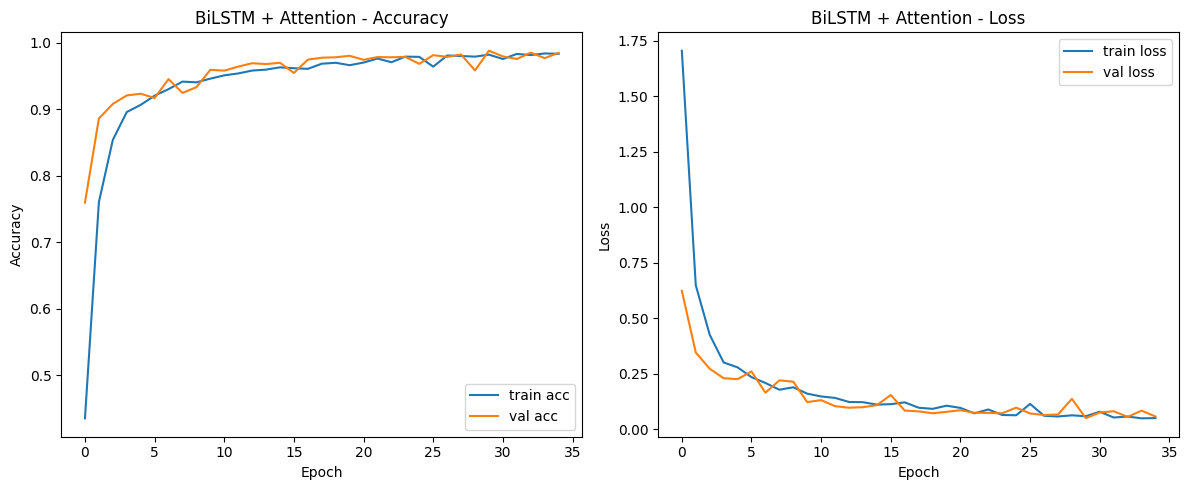

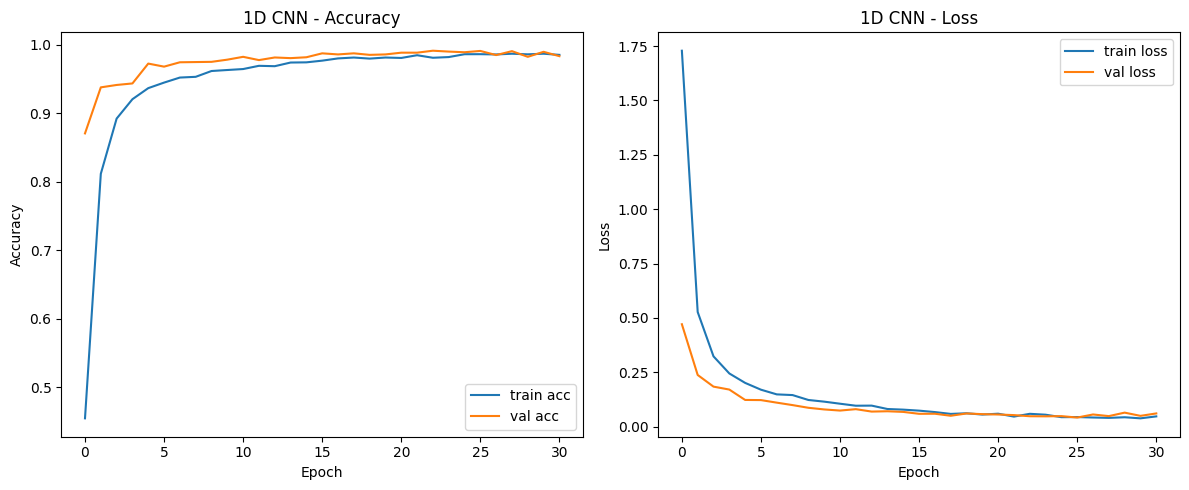

In [18]:
# Ewaluacja

import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_bilstm, "BiLSTM + Attention")
plot_history(history_cnn, "1D CNN")


In [19]:
# Ocena na zbiorze testowym
test_loss_bilstm, test_acc_bilstm = bilstm_model.evaluate(X_test, y_test, verbose=0)
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"BiLSTM + Attention — Accuracy: {test_acc_bilstm:.4f}, Loss: {test_loss_bilstm:.4f}")
print(f"1D CNN           — Accuracy: {test_acc_cnn:.4f}, Loss: {test_loss_cnn:.4f}")


BiLSTM + Attention — Accuracy: 0.9902, Loss: 0.0452
1D CNN           — Accuracy: 0.9916, Loss: 0.0340


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


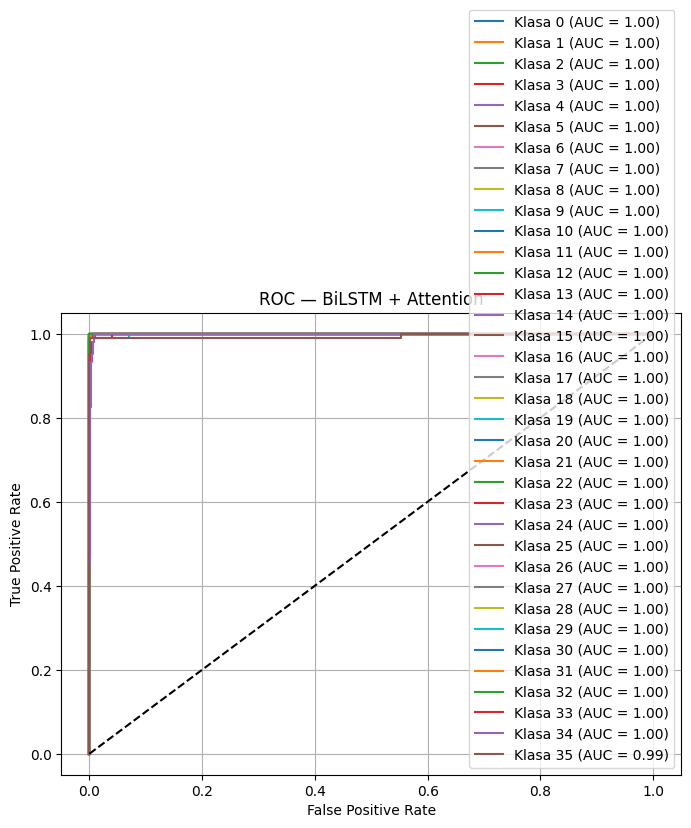

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


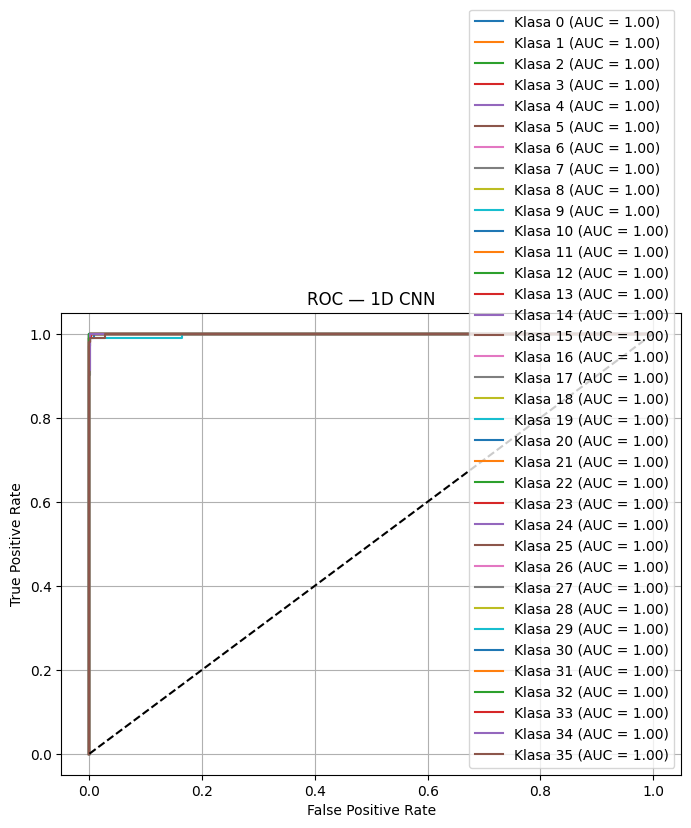

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

def plot_multiclass_roc(model, X, y_true_cat, model_name):
    y_score = model.predict(X)
    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = y_true_cat.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_cat[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Klasa {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC — {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_multiclass_roc(bilstm_model, X_test, y_test, "BiLSTM + Attention")
plot_multiclass_roc(cnn_model, X_test, y_test, "1D CNN")


In [25]:
import os
from datetime import datetime
import json

# Ustal dzisiejszą datę
today_str = datetime.now().strftime("%Y-%m-%d")

# Ścieżka zapisu modeli
save_dir = f"../model/{today_str}"
os.makedirs(save_dir, exist_ok=True)

# Ścieżki plików
bilstm_path = os.path.join(save_dir, "bilstm_model.keras")
# cnn_path = os.path.join(save_dir, "cnn_1d_model.keras")
labels_path = os.path.join(save_dir, "labels.txt")

# Zapis modeli
bilstm_model.save(bilstm_path)
# cnn_model.save(cnn_path)

with open(f'../model/{today_str}/labels.txt', 'w+') as f:
    for label in le.classes_:
        f.write(label + '\n')

print(f"Modele i etykiety zapisano w folderze: {save_dir}")


Modele i etykiety zapisano w folderze: ../model/2025-09-16
